In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import urllib.request
urllib.request.urlretrieve('https://universe.roboflow.com/ds/nWWXWRJ8Wg?key=LgAXgcLLr1', '/content/drive/MyDrive/ITRI ScrewNuts/Dataset/see_bolts-nuts.v3i.multiclass.zip')
os.listdir()

In [ ]:
import os
os.makedirs('/content/dataset/boltnut')
!unzip "/content/drive/MyDrive/ITRI ScrewNuts/Dataset/see_bolts-nuts.v3i.multiclass.zip" -d /content/dataset/boltnut

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
import os.path
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_image_dir = "/content/dataset/boltnut/train/"
test_image_dir = "/content/dataset/boltnut/test/"
valid_image_dir = "/content/dataset/boltnut/valid/"

train_annotations = pd.read_csv("/content/dataset/boltnut/train/_classes.csv")
train_annotations.columns = train_annotations.columns.str.strip()
train_annotations = train_annotations[(train_annotations['screw_body'] != 1) & (train_annotations['screw_head'] != 1)]

test_annotations = pd.read_csv("/content/dataset/boltnut/test/_classes.csv")
test_annotations.columns = test_annotations.columns.str.strip()
test_annotations = test_annotations[(test_annotations['screw_body'] != 1) & (test_annotations['screw_head'] != 1)]

valid_annotations = pd.read_csv("/content/dataset/boltnut/valid/_classes.csv")
valid_annotations.columns = valid_annotations.columns.str.strip()
valid_annotations = valid_annotations[(valid_annotations['screw_body'] != 1) & (valid_annotations['screw_head'] != 1)]

classes = ['bolt', 'nut']

In [ ]:
print ("Train data:", len(train_annotations.axes[0]))
print ("Test data:", len(test_annotations.axes[0]))
print ("Valid data:", len(valid_annotations.axes[0]))

Train data: 2109
Test data: 62
Valid data: 119


In [ ]:
train_annotations['label'] = train_annotations.apply(lambda row: 1 if row['nut'] == 1 else 0, axis=1)
train_annotations = train_annotations.drop(columns=['bolt', 'nut', 'screw_body', 'screw_head'])

test_annotations['label'] = test_annotations.apply(lambda row: 1 if row['nut'] == 1 else 0, axis=1)
test_annotations = test_annotations.drop(columns=['bolt', 'nut', 'screw_body', 'screw_head'])

valid_annotations['label'] = valid_annotations.apply(lambda row: 1 if row['nut'] == 1 else 0, axis=1)
valid_annotations = valid_annotations.drop(columns=['bolt', 'nut', 'screw_body', 'screw_head'])

In [ ]:
valid_annotations.head()

In [ ]:
train_images = []
train_annotations_list = []
test_images = []
test_annotations_list = []
valid_images = []
valid_annotations_list = []

for index, row in train_annotations.iterrows():
      filename = row['filename']
      image_path = os.path.join(train_image_dir, filename)
      image = cv2.imread(image_path)
      image = cv2.resize(image, (224, 224))
      image = image.astype('float32') / 255.0
      train_images.append(image)
      train_annotations_list.append(row['label'])

for index, row in test_annotations.iterrows():
      filename = row['filename']
      image_path = os.path.join(test_image_dir, filename)
      image = cv2.imread(image_path)
      image = cv2.resize(image, (224, 224))
      image = image.astype('float32') / 255.0
      test_images.append(image)
      test_annotations_list.append(row['label'])

for index, row in valid_annotations.iterrows():
      filename = row['filename']
      image_path = os.path.join(valid_image_dir, filename)
      image = cv2.imread(image_path)
      image = cv2.resize(image, (224, 224))
      image = image.astype('float32') / 255.0
      valid_images.append(image)
      valid_annotations_list.append(row['label'])

In [ ]:
train_images = np.array(train_images)
train_annotations_array = np.array(train_annotations_list)
test_images = np.array(test_images)
test_annotations_array = np.array(test_annotations_list)
valid_images = np.array(valid_images)
valid_annotations_array = np.array(valid_annotations_list)

train_annotations_one_hot = to_categorical(train_annotations_array, num_classes=2)  # Assuming 2 classes (0 or 1)
test_annotations_one_hot = to_categorical(test_annotations_array, num_classes=2)    # Assuming 2 classes (0 or 1)
valid_annotations_one_hot = to_categorical(valid_annotations_array, num_classes=2)    # Assuming 2 classes (0 or 1)

In [ ]:
model = Sequential(name='Bolt_Nuts_Model')

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "Bolt_Nuts_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 96)        55392     
                                                                 
 flatten (Flatten)           (None, 259584)        

In [ ]:
import time

log_base = '/content/logs/' + time.strftime("%Y%m%d%H%M%S", time.localtime())
model_dir = log_base + '/models/'
os.makedirs(model_dir)

In [ ]:
log_dir = os.path.join(log_base, 'log')
model_cbk = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = tf.keras.callbacks.ModelCheckpoint(model_dir + '/Bolt_Nuts_Model.h5',
                                        monitor='accuracy',
#                                        monitor='val_mean_absolute_error',
                                        save_best_only=True,
                                        mode='min')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(train_images, train_annotations_one_hot, epochs=15, batch_size=64, validation_data=(valid_images, valid_annotations_one_hot), callbacks=[model_cbk, model_mckp])

In [ ]:
model.save('Bolt_Nuts_Model.h5')
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:

test_loss, test_accuracy = model.evaluate(test_images, test_annotations_one_hot)
print(f'Test accuracy: {test_accuracy}')

2/2 [==============================] - 0s 26ms/step - loss: 0.3573 - accuracy: 0.9194
Test accuracy: 0.9193548560142517


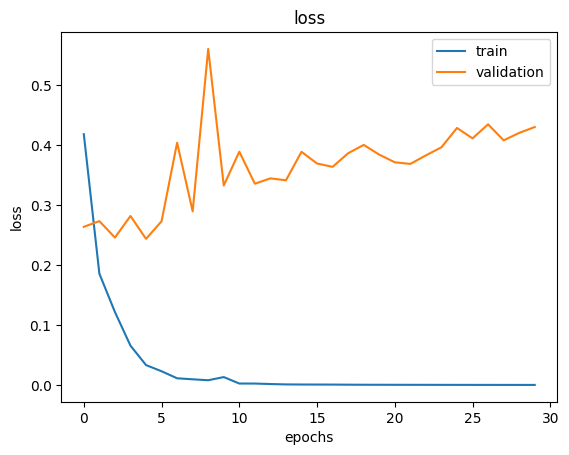

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

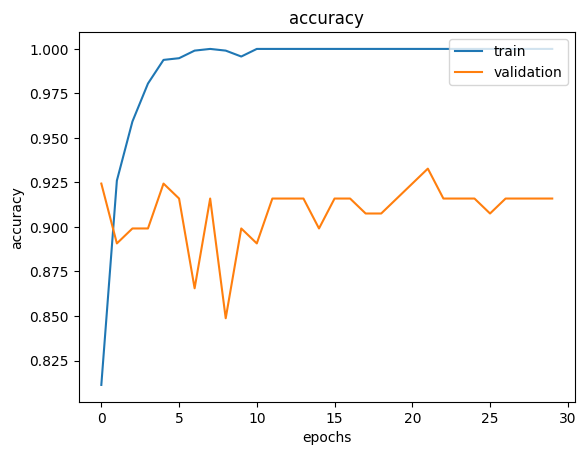

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
# plt.ylim(0.0, 0.01)
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [ ]:
loss, accuracy = model.evaluate(test_images, test_annotations_one_hot)
print ("loss: {}, accuracy: {}".format(loss, accuracy))

2/2 [==============================] - 0s 28ms/step - loss: 0.3128 - accuracy: 0.9355
loss: 0.3127586543560028, accuracy: 0.9354838728904724


2/2 [==============================] - 0s 27ms/step - loss: 0.3573 - accuracy: 0.9194
Test accuracy: 0.9193548560142517
2/2 [==============================] - 0s 19ms/step


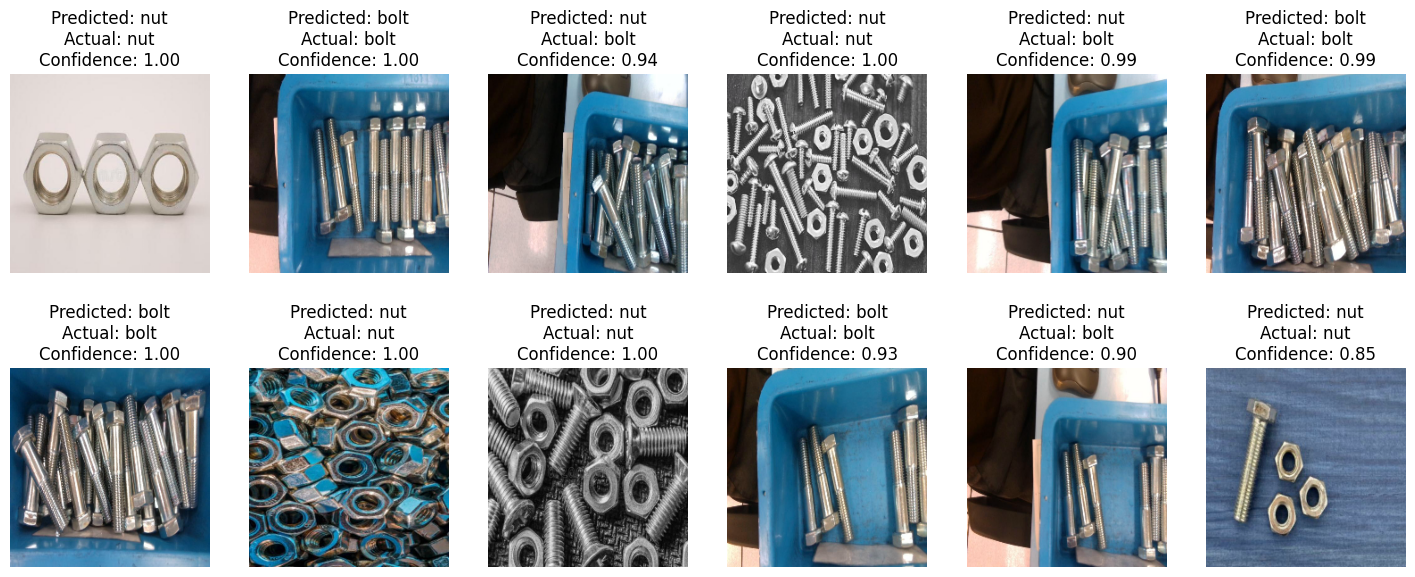

In [ ]:
import numpy as np

test_loss, test_accuracy = model.evaluate(test_images, test_annotations_one_hot)
print(f'Test accuracy: {test_accuracy}')


predictions = model.predict(test_images)

random_indices = np.random.choice(len(test_images), size=12, replace=False)

plt.figure(figsize=(18, 7))
for i, idx in enumerate(random_indices):
    predicted_label = np.argmax(predictions[idx])
    confidence = predictions[idx][predicted_label]
    actual_label = test_annotations_array[idx]

    plt.subplot(2, 6, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f'Predicted: {classes[predicted_label]}\nActual: {classes[actual_label]}\nConfidence: {confidence:.2f}')
    plt.axis('off')

plt.show()

